# Trigram name generator

### This is an fun exercise inspired by Andrej Kaparthy's building makemore exercise where he nade a name generator using a bigram model.

### Here I have implemented the trigram version, theoretically it should perform better so lets have a look

In [8]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [247]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Read in names
words = open('names.txt', 'r').read().splitlines()

# All possible characters
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for c, i in stoi.items()}

In [10]:
# Matrix to keep trigram count
# 27x27x27 matrix as each character pair would have a count of what the last character is.
N = torch.zeros((27, 27, 27), dtype=torch.int32)

In [11]:
# Populating N with trigrams that we get from training dataset
for w in words:
    chs = ['.'] + list(w) + ['.'] # Speical start token
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        N[stoi[ch1], stoi[ch2], stoi[ch3]] += 1

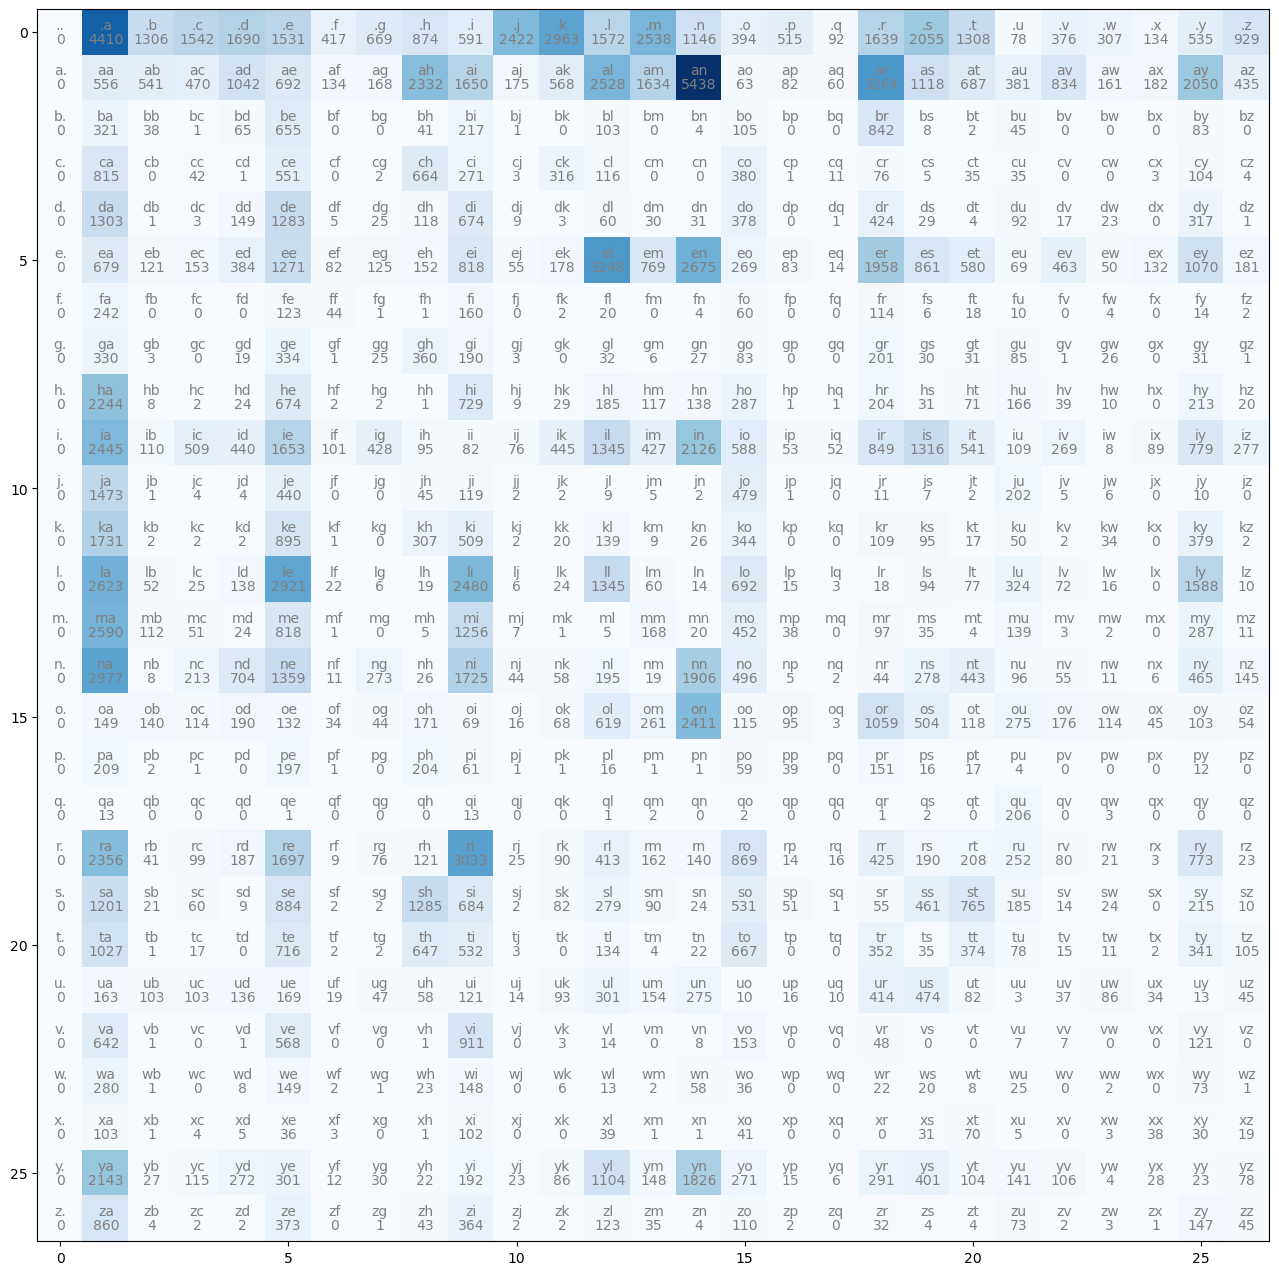

In [12]:
# Can't plot 3D so I compressed the 3rd letters count, making this a bigram
# (but not so) representation. As we can see the .. fields are all of count 0,
# that's because there will never be a triplet "a.a", that is invalid

# Plotting our trigram count matrix
N_visualize = N.sum(dim=2, keepdim=False)

plt.figure(figsize=(16, 16))
plt.imshow(N_visualize, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, N_visualize[i,j].item(), ha='center', va='top', color='gray')

plt.show()


## This will be the trigram emperical counting method of generating names

In [105]:
P = (N + 1).float()
P /= P.sum(dim = 2, keepdim=True)

def generate_name():
    start_row = 0
    name = ""
    start_length = 1
    curr, prev = stoi["."], None
    while True:
        if not prev:
            starting = P[0, :, :].view(1, 27, 27).sum(dim=1)
            starting /= starting.sum(dim = 1, keepdim=True)
            p = starting
        else:
            p = P[prev, curr, :]

        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        
        # print(itos.get(prev, None), itos[curr], itos[idx], p)
        if idx == 0:
            break

        prev = curr
        curr = idx
        name += itos[idx]
        
    print(name)

for _ in range(5):
    generate_name()

ie
wzian
rhyaana
aiana
aakayly


In [102]:
# Calculating the NLL loss of this model

# for w in words[:10]:
total_loss = 0.0

for w in words:
    score= 0.0
    n = 0
    chs = ['.'] + list(w) + ['.'] # Speical start token
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1, ix2, ix3 = stoi[ch1], stoi[ch2], stoi[ch3]
        n += 1
        prob = P[ix1, ix2, ix3]
        score += torch.log(prob)

    total_loss += score / n

# The lower the score the better
print(f"Training: Average NLL Loss: {-1 *total_loss / len(words):4f}")

Training: Average NLL Loss: 2.110602


### So from what we can see, our emperical loss with trigram is 2.11, which is the theoretical "Minimum" loss that we can achieve with the closed training set.
### So we will now checkout if a simple linear feedfoward network with a softmax layer can reach or even beat this loss.

# Now for the neural network version

Structure of our "neural network". So suppose we have B training samples, where training samples are basically trigrams. So our training input would be (a, b) and training output is (c). We do it in this form as we would want to use the previous 2 characters to predict the 3rd character.

To do this we would have to one-hot encode the x characters with num_classes = 729 (27*27) for every possible permutation of two characters. 

Henceforth, our input matrix would have size Bx729.
Then we put it through a linear FF network of size 729x27. Output size is 27 as we would want to create a probability distribution across the 27 characters we have.

Then we put it through a softmax which gives us the probability distribution.

In [170]:
biwords = set()
for i in range(len(chars)):
    for j in range(len(chars)):
        biwords.add(chars[i] + chars[j])
       
itos2 = {i:l for i,l in enumerate(biwords)}
stoi2 = {l:i for i,l in enumerate(biwords)}

In [246]:
# Set up training data and labels
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.'] # Speical start token
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1, ix2, ix3 = stoi[ch1], stoi[ch2], stoi[ch3]
        idx = stoi2[ch1 + ch2]
        x1enc = F.one_hot(torch.tensor([idx]), num_classes=len(stoi2.items())).float()
        xs.append(x1enc)
        ys.append(ix3)

xs, ys = torch.cat(xs).float(), torch.tensor(ys)
num_pairs = len(itos2.items())

In [188]:
W = torch.randn((num_pairs, 27), requires_grad=True).to(device)
xs, ys = xs.to(device), ys.to(device)

In [248]:
lr = 50
iterations = 1000
lmbd = 0.0001 # Lambda for regularization

for step in range(iterations):
    logits = xs @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -1  * probs[torch.arange(xs.shape[0]), ys].log().mean() + lmbd*(W ** 2).mean()

    # backward pass
    W.grad = None
    loss.backward()
    
    W.data += -lr * W.grad
    
    if step % 50 == 0:
        print(loss.item())
    

2.0727453231811523
2.0726613998413086
2.0725784301757812
2.0724966526031494
2.0724165439605713
2.0723371505737305
2.072258710861206
2.0721819400787354


In [245]:
def generate_name():
    index = 0
    prev = 0
    name = ""
    while True:
        xenc = F.one_hot(torch.tensor([stoi2[itos[prev] + itos[index]]]), num_classes=num_pairs).float()
        
        logits = xenc @ W # Get probability distribution per character
        logits = logits.exp()
        p = logits / logits.sum(dim=1, keepdim= True)
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()

        if idx == 0:
            break

        prev = index
        index = idx
        name += itos[idx]
        
    print(name)

for _ in range(5):
    generate_name()

NameError: name 'num_pairs' is not defined

### To my surprise, our neural network model has outperformed the emperical trigram counting method. Although the improvement is very small ~0.04, it is still a big difference as I though that that would be the lowest lost that we can achieve as we are iterating through the training set. 

### However, we are definitely overfitting to our training data (So if our model were to see new names, our loss would be very high)

### In comparison with the bigram model we had, our loss is a lot better ~0.3 lower.